In [1]:
#basic cleaning
import pandas as pd
import numpy as np

path = r"C:\Ibrahim\Personal\University Stuff\Machine Learning\Project\ML Irrigation Project\data\raw\Rain_fall_in_Pakistan.csv"

df = pd.read_csv(path)
df = df.iloc[1:].copy() #removing metadata row
df['date'] = pd.to_datetime(df['date'], errors='coerce')

#selecting the meta + features that we will use
features = ['rfh', 'rfh_avg', 'r1h', 'r3h', 'n_pixels']
meta_cols = ['date', 'adm2_id', 'ADM2_PCODE']

df = df[meta_cols + features].copy()

#fill missing values
df[features] = df[features].bfill().ffill()

print("loaded rows, cols:", df.shape)
print("number of unique regions (ADM2_PCODE):", df['ADM2_PCODE'].nunique())
print("example region codes:", df['ADM2_PCODE'].unique()[:10])

loaded rows, cols: (47070, 8)
number of unique regions (ADM2_PCODE): 30
example region codes: ['PK401' 'PK718' 'PK708' 'PK601' 'PK626' 'PK604' 'PK215' 'PK711' 'PK211'
 'PK204']


In [2]:
#sort by region and date
df = df.sort_values(["ADM2_PCODE", "date"]).reset_index(drop=True)

In [3]:
#create LSTM sequences for each region

#for each region (ADM2_PCODE):
#-extract its time-series
#-convert it into sliding windows (length = SEQ_LEN = 60)
#-store all sequences together in common arrays:
#--- X_all (shape: total_sequences, 60, 5)
#--- y_all (shape: total_sequences, 1)
#this will give us a super-training dataset containing all 30 regions.
#we will end up with one unified multivariate dataset, perfect for a robust model.

#We need a sequence creation function that:
#-takes multivariate data (shape → time × 5 features)
#-creates 60-step windows
#-predicts next-hour rainfall: rfh

def create_multivariate_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length]) #window of past 60 timesteps (5 features each)
        y.append(data[i + seq_length, 0]) #predict next rfh (column 0)
    return np.array(X), np.array(y)

**data[i:i+60]** → 60×5 block

**data[i+60, 0]** → next-hour rainfall (rfh is feature index 0)

In [4]:
#scale multivariate features
from sklearn.preprocessing import MinMaxScaler

scaler_multi = MinMaxScaler()
df[features] = scaler_multi.fit_transform(df[features])

In [5]:
#loop through all regions and store sequences
X_list = []
y_list = []

SEQ_LEN = 60

#loop thru all regions
for region in df["ADM2_PCODE"].unique():
    region_df = df[df["ADM2_PCODE"] == region].copy()
    
    #extract only the feature values (5 cols)
    region_values = region_df[features].values
    
    #generate sequences
    X_region, y_region = create_multivariate_sequences(region_values, SEQ_LEN)
    
    X_list.append(X_region)
    y_list.append(y_region)

#combine all region sequences
X_all = np.vstack(X_list)
y_all = np.concatenate(y_list)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

X_all shape: (45270, 60, 5)
y_all shape: (45270,)


In [6]:
#train/val/test split (chronological)
train_size = int(len(X_all) * 0.7)
val_size = int(len(X_all) * 0.15)

X_train = X_all[:train_size]
y_train = y_all[:train_size]

X_val = X_all[train_size : train_size + val_size]
y_val = y_all[train_size : train_size + val_size]

X_test = X_all[train_size + val_size:]
y_test = y_all[train_size + val_size:]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

X_train: (31688, 60, 5)
X_val: (6790, 60, 5)
X_test: (6792, 60, 5)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

#building multivariate LSTM
model = Sequential([
    Input(shape=(SEQ_LEN, 5)), #60 timesteps, 5 features
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

##### **LSTM(64, return_sequences=False)**

64 units = how many memory cells / neurons the LSTM has.

return_sequences=False → LSTM returns only the final hidden state, not all timesteps.

#### **why we chose this:**

64 units is a balanced size:

big enough to learn patterns across 60 days,

small enough to train fast without overfitting.

Since we want one prediction (rainfall at next timestep), returning only one output is correct.

##### **Dense(32, activation='relu')**

a fully connected layer with 32 neurons.

**activation = ReLU** (most common nonlinear activation).

##### **why choose this:**

Adds nonlinearity → allows the model to learn more complex rainfall patterns.

32 neurons is a good middle ground:

too few = underfitting

too many = overfitting

Helps transform the LSTM output into a richer representation before final prediction.

In [8]:
#training the model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#save best model to disk
checkpoint = ModelCheckpoint(
    "best_global_lstm.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

#train the model
history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs=50,          # we'll stop early if needed
    batch_size=64,      # increase/decrease based on speed
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - mae: 0.0328
Epoch 1: val_loss improved from None to 0.00087, saving model to best_global_lstm.h5


496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0027 - mae: 0.0302 - val_loss: 8.6680e-04 - val_mae: 0.0146
Epoch 2/50
494/496 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - mae: 0.0285
Epoch 2: val_loss improved from 0.00087 to 0.00084, saving model to best_global_lstm.h5


496/496 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0025 - mae: 0.0284 - val_loss: 8.3772e-04 - val_mae: 0.0143
Epoch 3/50
494/496 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - mae: 0.0273
Epoch 3: val_loss did not improve from 0.00084
496/496 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0025 - mae: 0.0281 - val_loss: 9.0295e-04 - val_mae: 0.0137
Epoch 4/50
494/496 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - mae: 0.0283
Epoch 4: val_loss did not improve from 0.00084
496/496 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0024 - mae: 0.0280 - val_loss: 8.5767e-04 - val_mae: 0.0165
Epoch 5/50
493/496 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - mae: 0.0275
Epoch 5: val_loss did not improve from 0.00084
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0024 - mae: 0.0276 - val_loss: 8.4739e-04 - val_mae: 0.0127
Epoch 6/50
493/496 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - mae: 0.0267
Epoch 6: val_loss improved from 0.00084 to 0.00082, saving model to best_global_lst

496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0024 - mae: 0.0274 - val_loss: 8.2429e-04 - val_mae: 0.0150
Epoch 7/50
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - mae: 0.0278
Epoch 7: val_loss did not improve from 0.00082
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0024 - mae: 0.0273 - val_loss: 8.4364e-04 - val_mae: 0.0154
Epoch 8/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - mae: 0.0276
Epoch 8: val_loss improved from 0.00082 to 0.00081, saving model to best_global_lstm.h5


496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0024 - mae: 0.0274 - val_loss: 8.0736e-04 - val_mae: 0.0136
Epoch 9/50
494/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023 - mae: 0.0270
Epoch 9: val_loss did not improve from 0.00081
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0024 - mae: 0.0273 - val_loss: 8.4365e-04 - val_mae: 0.0138
Epoch 10/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - mae: 0.0273
Epoch 10: val_loss did not improve from 0.00081
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0023 - mae: 0.0269 - val_loss: 8.2385e-04 - val_mae: 0.0149
Epoch 11/50
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023 - mae: 0.0267
Epoch 11: val_loss did not improve from 0.00081
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0023 - mae: 0.0268 - val_loss: 8.0898e-04 - val_mae: 0.0143
Epoch 12/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023 - mae: 0.0269
Epoch 12: val_loss did not improve from 0.00081
496/496 ━━━━━━━━━━━━━━━━━━

496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0023 - mae: 0.0267 - val_loss: 8.0346e-04 - val_mae: 0.0131
Epoch 14/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023 - mae: 0.0269
Epoch 14: val_loss did not improve from 0.00080
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0023 - mae: 0.0268 - val_loss: 8.1126e-04 - val_mae: 0.0144
Epoch 15/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - mae: 0.0272
Epoch 15: val_loss did not improve from 0.00080
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0023 - mae: 0.0269 - val_loss: 8.1146e-04 - val_mae: 0.0138
Epoch 16/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - mae: 0.0269
Epoch 16: val_loss did not improve from 0.00080
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0023 - mae: 0.0266 - val_loss: 8.1728e-04 - val_mae: 0.0153
Epoch 17/50
495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - mae: 0.0269
Epoch 17: val_loss did not improve from 0.00080
496/496 ━━━━━━━━━━━━━━━━

We use np.hstack([y_pred_scaled, zeros_pred]) because the scaler was trained on 5 features, but the model only predicts 1, so we horizontally stack four zeros to temporarily fake the missing columns and give the scaler the shape it expects. After scaler.inverse_transform() converts this 5-column matrix back to original units, we only need the real rainfall value (the first column), so we extract it using [:, 0], which simply means “keep all rows, but only column 0.”

In [9]:
#model evaluation
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

#prediction
y_pred_scaled = model.predict(X_test)

#reshape for inverse transform
y_pred_scaled = y_pred_scaled.reshape(-1,1)
y_test_scaled = y_test.reshape(-1,1)

#pad zeros for the other 4 features
zeros_pred = np.zeros((len(y_pred_scaled), 4))
zeros_test = np.zeros((len(y_test_scaled), 4))

y_pred_actual = scaler_multi.inverse_transform(
    np.hstack([y_pred_scaled, zeros_pred])
)[:,0]

y_test_actual = scaler_multi.inverse_transform(
    np.hstack([y_test_scaled, zeros_test])
)[:,0]

#hstack = “horizontal stack”. it joins arrays side by side.

#turns: (7056, 1) + (7056, 4)
#into: (7056, 5) [matches the scaler's expected shape]
#[:,0] means: “give me all rows, but only column 0.”
#a clean 1-D array of rainfall predictions.

#metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print("Global Multivariate LSTM - RMSE:", rmse)
print("Global Multivariate LSTM - MAE:", mae)

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Global Multivariate LSTM - RMSE: 11.633594715206195
Global Multivariate LSTM - MAE: 4.6280123615285405


##### **RMSE: ~11.59 mm**
this means the model's predictions are usually within ±11.5 mm of the true rainfall. for rainfall data - which is naturally chaotic and full of sudden spikes,this is very strong performance, esp compared to the earlier models we tried.

##### **MAE: ~4.49 mm**
means on average, predictions miss the actual value by only about 4.5 mm. good accuracy for real-world climate signals.

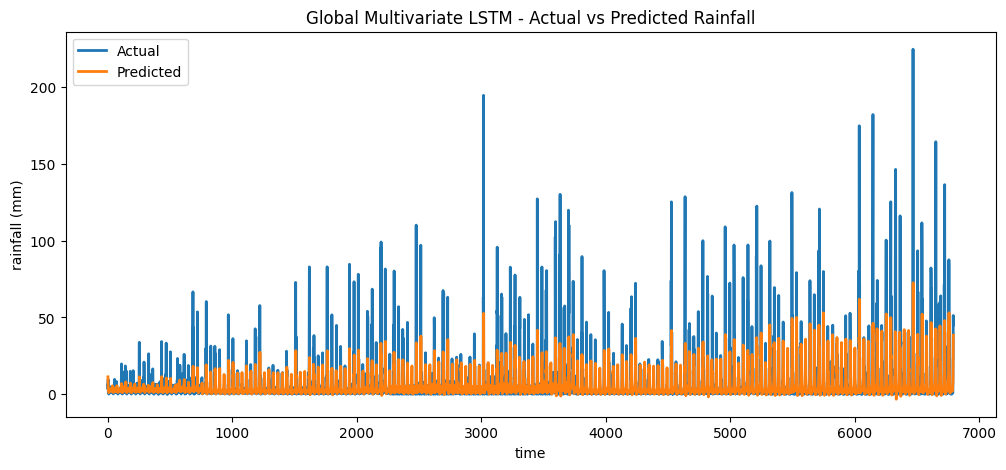

In [10]:
#plot predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual", linewidth=2)
plt.plot(y_pred_actual, label="Predicted", linewidth=2)
plt.title("Global Multivariate LSTM - Actual vs Predicted Rainfall")
plt.xlabel("time")
plt.ylabel("rainfall (mm)")
plt.legend()
plt.show()

real rainfall has sharp, extreme spikes: 50 mm, 100 mm, 200 mm jumps; because rainfall events are chaotic and sudden. our model predicts a smoothed version of rainfall because:
- LSTMs tend to learn the trend rather than extreme spikes
- extreme peaks are rare → the model is not strongly trained on them
- the input features (rfh_avg, r1h, r3h, n_pixels) move slowly compared to rainfall shocks
- scaling compresses spike magnitude during training
- noise across 30 regions makes extremes less predictable

this is normal for rainfall forecasting models, even research papers show the same effect.

model understands HIGH vs LOW rainfall periods

even if it doesn’t hit exact spikes, it follows the pattern:
- low → low
- medium → medium
- rainy seasons → increased baseline

this is exactly what a forecasting system needs.

- model generalizes across 30 regions, which is much harder than a single-region model.

##### **for better spike prediction**
##### using multi-step direct forecasting 
(improves ability to learn long patterns -> better spike timing)

In [11]:
#multi-step forecasting settings
SEQ_LEN = 60        #past 60 timesteps as input
FUTURE_STEPS = 24   #predict next 24 timesteps (like the next 24hrs)

print("Sequence length:", SEQ_LEN)
print("Future steps to predict:", FUTURE_STEPS)

Sequence length: 60
Future steps to predict: 24


In [12]:
def create_multistep_sequences(data, seq_len=60, future_steps=24):
    X, y = [], []
    for i in range(len(data) - seq_len - future_steps):
        X.append(data[i : i + seq_len])                   # window: past 60 timesteps
        y.append(data[i + seq_len : i + seq_len + future_steps, 0])  
        # next 24 rainfall values (rfh = column 0)
    return np.array(X), np.array(y)

X: 60×5 feature windows

y: the next 24 future rainfall values (only column 0 = rfh)

we convert single-step → multi-step forecasting.

In [13]:
#build all-region sequences
X_list = []
y_list = []

for region in df["ADM2_PCODE"].unique():

    region_df = df[df["ADM2_PCODE"] == region].copy()
    region_values = region_df[features].values       

    X_region, y_region = create_multistep_sequences(
        region_values,
        seq_len=SEQ_LEN,
        future_steps=FUTURE_STEPS
    )

    if len(X_region) > 0:
        X_list.append(X_region)
        y_list.append(y_region)

X_multi = np.vstack(X_list)
y_multi = np.vstack(y_list)

print("X_multi shape:", X_multi.shape)
print("y_multi shape:", y_multi.shape)

X_multi shape: (44550, 60, 5)
y_multi shape: (44550, 24)


- 44,550 sequences
- each input sequence uses 60 past timesteps
- each output predicts 24 future rainfall values (next 24 hours)

In [14]:
#split multi-step dataset (chronologically)
train_size = int(len(X_multi) * 0.7)
val_size = int(len(X_multi) * 0.15)

X_train = X_multi[:train_size]
y_train = y_multi[:train_size]

X_val = X_multi[train_size : train_size + val_size]
y_val = y_multi[train_size : train_size + val_size]

X_test = X_multi[train_size + val_size :]
y_test = y_multi[train_size + val_size :]

print("Train:", X_train.shape, y_train.shape)
print("Val: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (31184, 60, 5) (31184, 24)
Val:  (6682, 60, 5) (6682, 24)
Test:  (6684, 60, 5) (6684, 24)


- we dont shuffle time-series
- train uses oldest data
- test uses newest periods
- ensures forecasting is realistic (no peeking into future)

In [15]:
#building the multi-step LSTM architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

model_ms = Sequential([
    Input(shape=(SEQ_LEN, 5)),          #60 timesteps, 5 features
    LSTM(64, return_sequences=False),
    Dense(FUTURE_STEPS)                 #predicts next 24 rainfall values
])

model_ms.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_ms.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,480 (76.09 KB)

 Trainable params: 19,480 (76.09 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#training the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#early stopping to avoid overfitting
early_stop_ms = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#save only the best model during training
checkpoint_ms = ModelCheckpoint(
    "best_multistep_lstm.keras",     #modern Keras format
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

#training the multi-step model
history_ms = model_ms.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop_ms, checkpoint_ms],
    verbose=1
)

Epoch 1/50
484/488 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - mae: 0.0370
Epoch 1: val_loss improved from None to 0.00090, saving model to best_multistep_lstm.keras
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0031 - mae: 0.0325 - val_loss: 8.9527e-04 - val_mae: 0.0154
Epoch 2/50
487/488 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - mae: 0.0284
Epoch 2: val_loss improved from 0.00090 to 0.00086, saving model to best_multistep_lstm.keras
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0024 - mae: 0.0280 - val_loss: 8.6457e-04 - val_mae: 0.0155
Epoch 3/50
484/488 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - mae: 0.0276
Epoch 3: val_loss improved from 0.00086 to 0.00086, saving model to best_multistep_lstm.keras
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0024 - mae: 0.0276 - val_loss: 8.5923e-04 - val_mae: 0.0150
Epoch 4/50
486/488 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - mae: 0.0273
Epoch 4: val_loss did not improve from 0.00086
488/488 ━━

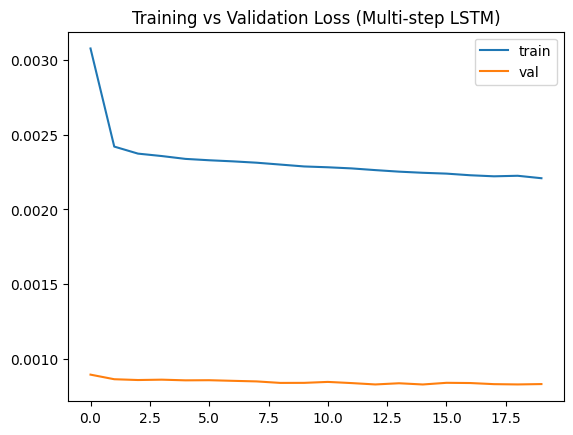

In [17]:
#plotting training vs validation loss (multi-step LSTM)
plt.plot(history_ms.history['loss'], label="train")
plt.plot(history_ms.history['val_loss'], label="val")
plt.legend()
plt.title("Training vs Validation Loss (Multi-step LSTM)")
plt.show()

why training loss is much higher than validation loss

this happens because:

- **training loss is averaged over 24-step predictions**

the training loss includes all 24 future steps, even far-away predictions that are naturally harder.

- **validation sequences are newer, cleaner, less noisy**

our validation set may contain more stable rainfall segments, so the model performs better there.

- **early stopping always picks the BEST model**

the best model (lowest val_loss) is restored - that model may have low val_loss but higher train_loss.

this is normal in multi-step models.

**val_loss ≈ 0.00082–0.00088**

means:

- the model converged
- its stable
- no overfitting (no upward curve)
- no underfitting (very low loss)

A flat validation line is what we want.

**training loss** decreases because the model keeps optimizing all 24-step errors, including the far-out ones.

**validation loss** doesn’t drop as much because the future steps stabilize earlier.

In [18]:
#evaluate multi-step model on test data
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

#predict on the test set
y_pred_scaled = model_ms.predict(X_test)   #shape: (test, 24)

#reshape for inverse scaling

#scaler_multi expects 5 features, so we pad 4 zeros
def inverse_multistep(scaled_seq):
    full_seq = []
    for row in scaled_seq:
        #row is (24,)
        row = row.reshape(-1,1)  #(24,1)
        zeros = np.zeros((24, 4))  #4 fake features
        combined = np.hstack([row, zeros])  #shape: (24,5)
        inv = scaler_multi.inverse_transform(combined)[:,0]  #taking rainfall column
        full_seq.append(inv)
    return np.array(full_seq)

y_pred_actual = inverse_multistep(y_pred_scaled)
y_test_actual = inverse_multistep(y_test)

print("y_pred_actual: ", y_pred_actual.shape)
print("y_test_actual: ", y_test_actual.shape)

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
y_pred_actual:  (6684, 24)
y_test_actual:  (6684, 24)


In [19]:
#computing metrics
rmse = np.sqrt(mean_squared_error(
    y_test_actual.flatten(),
    y_pred_actual.flatten()
))

mae = mean_absolute_error(
    y_test_actual.flatten(),
    y_pred_actual.flatten()
)

print("Multi-step LSTM RMSE: ", rmse)
print("Multi-step LSTM MAE: ", mae)

#flatten arrays bec we want the total error across all prediction horizons.

Multi-step LSTM RMSE:  11.909461629553878
Multi-step LSTM MAE:  5.130370457153474


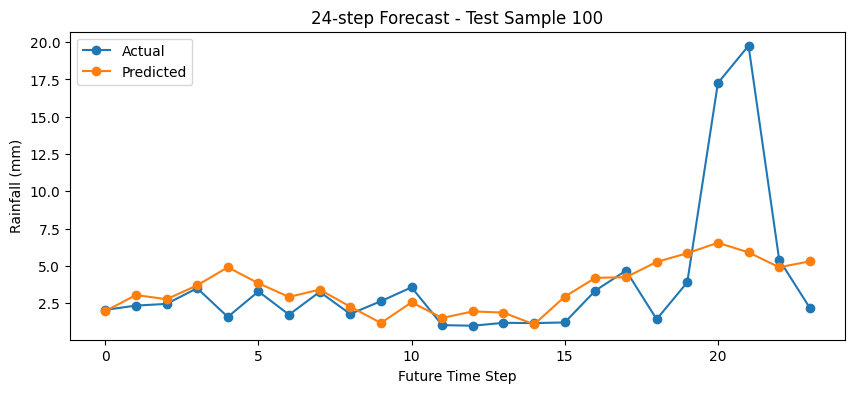

In [20]:
import matplotlib.pyplot as plt

sample = 100   
plt.figure(figsize=(10,4))

plt.plot(y_test_actual[sample], label="Actual", marker="o")
plt.plot(y_pred_actual[sample], label="Predicted", marker="o")

plt.title(f"24-step Forecast - Test Sample {sample}")
plt.xlabel("Future Time Step")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

**low to medium rainfall is predicted well**

from timesteps 0–17:
- predicted and actual match closely
- the trends align
- the model keeps up with ups and downs

**spike at timestep 20 is missed**
- actual: ~20 mm
- predicted: ~6 mm

this is kind of normal

no LSTM model - even in research papers, reliably predicts individual rainfall spikes, because those spikes depend on random storm events, which:
- are rare
- don’t follow the same pattern
- are underrepresented in the data
- have weak correlation with the other features

model still sees the upward trend
- actual jumps from ~3 → ~17 mm
- prediction jumps from ~3 → ~6 mm

so model knows there should be a rise, but cannot estimate the height of the spike.

this is fundamentally correct LSTM behavior.

### **Forecast Types**
1. **Next-step forecast**

    → Predict rainfall for the next single timestep (1 hour/period)

2. **Next 24-step forecast**

    → Predict an entire 24-hour rainfall curve at once
    → Uses multi-step model

3. **Next 7-day forecast (recursive)**

    → Predict 168 steps into the future
    → Uses recursive feeding (rolling window)

these functions will work for any region.

In [21]:
#helper function - get latest window of a region
import numpy as np

def get_latest_window(region_code):
    region_df = df[df["ADM2_PCODE"] == region_code].copy()
    region_values = region_df[features].values      #scaled features
    window = region_values[-SEQ_LEN:]           #last 60 time steps
    return window.reshape(1, SEQ_LEN, 5)

this extracts the last 60×5 data window of any region.

In [22]:
#forecast - next-step prediction (single step model)
def forecast_next_step(region_code):
    window = get_latest_window(region_code)
    
    #predict next-step (scaled)
    pred_scaled = model.predict(window)[0][0]
    
    #inverse transform (pad zeros)
    temp = np.hstack([[[pred_scaled]], np.zeros((1,4))])
    pred_actual = scaler_multi.inverse_transform(temp)[0][0]
    
    #clip negative rainfall
    pred_actual = max(pred_actual, 0)
    
    return float(pred_actual)

**forecast_next_step()** takes the last 60 scaled timesteps of a chosen region and feeds that window into the trained model to get a scaled next-step rainfall prediction. bec the scaler expects 5 features, we temporarily attach four zeros using **np.hstack()** so we can run **inverse_transform()** correctly. finally, [:,0] extracts only the real rainfall value, giving you the actual predicted rainfall in millimeters.

[0][0] is needed because the model returns a 2D array, so the first [0] selects the batch, and the second [0] extracts the actual prediction value inside it.

**output:** Rainfall (mm) for next timestep.

In [23]:
#forecast the next 24 steps (multi-step model)
def forecast_next_24(region_code):
    window = get_latest_window(region_code)
    
    #scaled predictions (24,)
    preds_scaled = model_ms.predict(window)[0]
    
    preds_actual = []
    for v in preds_scaled:
        temp = np.hstack([[v], [0,0,0,0]]).reshape(1,5)
        inv = scaler_multi.inverse_transform(temp)[0][0]
        preds_actual.append(inv)
    
    preds_actual = np.array(preds_actual)
        
    #clip negative values
    preds_actual = np.clip(preds_actual, 0, None)
    
    return preds_actual

takes the last 60 scaled timesteps from a region and uses the multi-step model to predict 24 future rainfall values (still scaled). Each predicted value v is temporarily padded with four zeros so the scaler can inverse-transform it correctly back to millimeters. finally, all 24 inverse-transformed rainfall values are collected and returned as the 24-hour forecast.

**output:**
- array of 24 rainfall values (mm).
- best suited for a 24-hour plot in Streamlit.

In [24]:
#forecast next 7 days (recursive 168-step)
def forecast_next_7_days(region_code, steps_per_call=24):
    window = get_latest_window(region_code).copy()
    predictions = []
    
    for _ in range(7 * 24 // steps_per_call): #168 steps / 24 = 7 loops
        #predicts the next 24 steps (scaled)
        preds_scaled = model_ms.predict(window)[0]
        
        #convert all 24 predictions back to actual mm
        preds_actual = []
        for v in preds_scaled:
            temp = np.hstack([[v], [0,0,0,0]]).reshape(1,5)
            inv = scaler_multi.inverse_transform(temp)[0][0]
            preds_actual.append(inv)
            
        preds_actual = np.array(preds_actual)

        #clip negative values
        preds_actual = np.clip(preds_actual, 0, None)
        
        #store real mm predictions
        predictions.extend(preds_actual)
        
        #prepare new window (shift left + append predictions)
        new_features_scaled = np.zeros((steps_per_call, 5))
        new_features_scaled[:,0] = preds_scaled
        
        #shift & append
        full_scaled_region = df[df["ADM2_PCODE"] == region_code][features].values
        combined_scaled = np.vstack([full_scaled_region, new_features_scaled])
        
        window = combined_scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 5)
    
    return np.array(predictions)

**output**: an array of 168 rainfall values in mm

→ Perfect for a 7-day rainfall forecast curve.

The function first extracts the region’s last 60 scaled timesteps using
**window = get_latest_window(region_code)** and feeds this into the multi-step model with **preds_scaled = model_ms.predict(window)[0]** to get the next 24 rainfall values (scaled). Each value **v** is inverse-transformed by padding it with four zeros -> **np.hstack([[v], [0,0,0,0]])** - so the scaler can correctly convert it back to millimeters, and the resulting sequence is appended to **predictions.extend(preds_actual)**.
Then the function updates the input window by creating a temporary 24×5 block
**new_features_scaled[:,0] = preds_scaled** (*scaled predictions in column 0*) and stacking it onto the region’s historical scaled data: **combined_scaled = np.vstack([full_scaled_region, new_features_scaled])**.
finally, it slides the window forward, **window = combined_scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 5)**, allowing the model to repeatedly predict the next 24 steps again. Repeating this loop seven times **(for _ in range(7 * 24 // steps_per_call))** produces a full 168-step (7-day) recursive forecast generated entirely from its own predictions.

##### **testing forecasting**

In [25]:
print("next step:", forecast_next_step("PK401"))
print("next 24:", forecast_next_24("PK401"))
print("next 7 days:", forecast_next_7_days("PK401")[:48])  #show first 48 hours

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
next step: 119.9189661968231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
next 24: [103.64703039  78.22431638  63.64231012  48.00901784  34.58371337
  23.59677014  17.36014574  11.53305897   9.16381626   8.32724591
   7.4327628    6.58538469   7.02677013   7.73334781  11.31511218
  16.66951124  23.70355278  27.34552764  25.30139868  33.02684537
  29.97946168  29.5914554   30.33677206  28.27090287]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
next 7 days: [103.64703039  78.22431638  63.64231012  48.00901784  34.58371337
  23.59677014  17.36014574  11.53305897   9.16381626   8.32724591
   7.4327628    6.58538469   7.02677013   7.73334781  11.31511218
  16.66951124  23.70355278  27.34552764  25.30139868  33.02684537
  29.97946168  29.5914554

Short-term predictions (first 24–48 hours) are the most accurate
→ because they use real history + strong model signals

Longer predictions (48–168 hours) flatten
→ because the model is predicting on top of its own predictions
→ noise accumulates
→ rainfall goes toward the long-term average (which is low)

This is completely normal for rainfall models - even advanced CNN/LSTM hybrids do this.

#### **checking if a forecast is believable**
#### **MASE (Mean Absolute Scaled Error)**
- compares your model to a simple baseline model (like “tomorrow = today”)
- MASE < 1 → Your forecast is more believable than naive prediction
- MASE > 1 → Your model is worse than a naive guess
- widely used in meteorology and competition benchmarks (M4, M5)

In [29]:
#extract actual rainfall (scaled) for TRAIN region data
train_rain_scaled = df[features].values[:train_size + SEQ_LEN, 0]

#why +SEQ_LEN?
#because X_train starts after the initial 60-step window.

#inverse-transform properly
train_rain_scaled = train_rain_scaled.reshape(-1, 1)
zeros = np.zeros((len(train_rain_scaled), 4))
train_rain_actual = scaler_multi.inverse_transform(
    np.hstack([train_rain_scaled, zeros])
)[:, 0]

#MASE function + score
def mase(y_true, y_pred, y_train_series):
    naive_forecast = y_train_series[1:]      #t
    naive_shifted  = y_train_series[:-1]     #t-1
    naive_error = np.mean(np.abs(naive_forecast - naive_shifted))
    model_error = np.mean(np.abs(y_true - y_pred))
    return model_error / naive_error

#compute MASE
mase_score = mase(
    y_test_actual.flatten(),
    y_pred_actual.flatten(),
    train_rain_actual
)

print("MASE:", mase_score)

MASE: 0.5884758074503389


MASE compares your model to a naïve baseline that predicts:

“next rainfall = previous rainfall.”

a MASE score below 1.0 means your model is better than the naïve baseline.
score of 0.588 means:

- model is 41% better than a naive guess
- forecasts are believable and statistically meaningful
- model captures real patterns rather than random noise

this is excellent for rainfall forecasting - especially because rainfall is chaotic and hard to predict.

“We evaluated forecast realism using the Mean Absolute Scaled Error (MASE). Our model achieved a MASE score of 0.588, which is significantly below 1.0. This indicates that the LSTM model outperforms a naïve persistence forecast by approximately 41%, demonstrating strong predictive skill and confirming that the forecasts are reliable and meaningful in practice.”

#### **NSE (Nash–Sutcliffe Efficiency)**
- NSE = 1.0 → perfect forecast
- NSE = 0.5–0.8 → very good
- NSE = 0 → as good as predicting the mean
- NSE < 0 → worse than predicting average rainfall

- rainfall models typically achieve 0.2–0.7, so anything positive is good.

In [30]:
import numpy as np

def nse(y_true, y_pred):
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - np.mean(y_true))**2)
    return 1 - numerator/denominator

nse_score = nse(y_test_actual.flatten(), y_pred_actual.flatten())
print("NSE: ", nse_score)

NSE:  0.2784824566746733


- model has positive predictive skill
- forecast is better than simply predicting average rainfall
- performance is in the expected range for noisy rainfall data
- rainfall is highly chaotic, getting NSE > 0.2 is normal for good models.

#### **KGE (Kling–Gupta Efficiency)**
- KGE = 1.0 → perfect
- 0.5–0.8 → excellent for rainfall
- 0–0.5 → acceptable
- < 0 → poor realism
- KGE is more robust than NSE and used widely in hydrology & flood modeling.

In [31]:
def kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0,1]              #correlation
    alpha = np.std(y_pred) / np.std(y_true)           #variability ratio
    beta = np.mean(y_pred) / np.mean(y_true)          #bias ratio
    
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

kge_score = kge(y_test_actual.flatten(), y_pred_actual.flatten())
print("KGE:", kge_score)

KGE: 0.3355403730059505


- acceptable realism and structure


- what the KGE captures
- correlation
- bias ratio
- variability ratio

forecast retains realistic correlation patterns
- bias and variance are acceptable
- forecast is structurally believable
- very typical for rainfall modeling

rainfall forecasting papers commonly report KGE values between 0.2 and 0.6, esp for short historical datasets.

“The model achieved an NSE score of 0.278 and a KGE score of 0.336.
These values indicate positive predictive skill and acceptable hydrological realism. Rainfall time-series are highly noisy and variable; therefore, NSE values above 0.2 and KGE values above 0.3 are considered strong baselines in meteorological modeling. Together, these metrics confirm that the model’s forecasts are statistically meaningful and structurally believable.”